# Preliminaries and Imports

Notes:
- This notebook is somewhat adhoc. It loads a llama3 with LoRA model and predict on the test data. This explains the commented out code
- In case of error "Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes": The update is already implemented in the notebook. "Restart the session" and "Run all" again because the update seems to require a restart

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# system and path set up
import os
import sys

# path
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', 'ColabNotebooks', 'DL','Deep Learning Project Full','DL Team Project', '20251126_22.47_DL_Team_Project_Code_Files_Structure')

# set working directory (for saving/ loading)
os.chdir(GOOGLE_DRIVE_PATH)

# set import path (for importing src/)
sys.path.insert(0, GOOGLE_DRIVE_PATH)

# verify
print("Current working directory:", os.getcwd())
print("Current import directory:", sys.path[0])


Current working directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure
Current import directory: /content/drive/My Drive/ColabNotebooks/DL/Deep Learning Project Full/DL Team Project/20251126_22.47_DL_Team_Project_Code_Files_Structure


In [ ]:
# log into HF
# note: previously store your key as secret (key symbol on the left)
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

from huggingface_hub import login
login(token=hf_token)

# Option: silence all HF logs
from transformers.utils.logging import set_verbosity_error
set_verbosity_error()

In [ ]:
# install libraries (only once and then comment out)
!pip install -q "transformers>=4.40.0" accelerate datasets peft bitsandbytes trl
!pip install -q -U bitsandbytes transformers accelerate peft trl

In [ ]:
# import standard libraries
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
import torch
from peft import LoraConfig
from peft import PeftModel # for loading

# import utils
from src import utils

# import model
from src.model_llama_lora import CommonMethods, LlamaBaseModel, LlamaLoraModel

# create instance object of CommonMethods
cm = CommonMethods()

In [ ]:
# set seed for reproduceibility (Note: does not work for OpenAI)
seed = 42

# Load and prepare data

In [ ]:
# load pre-processed data
csv_path_train_data = f"{GOOGLE_DRIVE_PATH}/data/data_train.csv"
csv_path_val_data = f"{GOOGLE_DRIVE_PATH}/data/data_val.csv"
csv_path_test_data = f"{GOOGLE_DRIVE_PATH}/data/data_test.csv"

train_bal = pd.read_csv(csv_path_train_data)
val = pd.read_csv(csv_path_val_data)
test = pd.read_csv(csv_path_test_data)

In [ ]:
# keep only needed columns (drop lang and label5)
train_bal = train_bal.drop(columns=["label5","lang"])
val = val.drop(columns=["label5","lang"])
test = test.drop(columns=["label5","lang"])

In [ ]:
# downsample data
# Note: Fine-tuning on full data would take too long
train_bal = train_bal.sample(n=5000, random_state=seed)
val = val.sample(n=5000, random_state=seed)
test = test.sample(n=20000, random_state=seed)

# Run model/ Experiment

Specify model:
- Choose model type
- quant_config (= hyperparameters)
- lora_config (= hyperparameters)
- training_config (= hyperparameters)
- Instruction (= hyperparameters)

Specify data for evaluation:
- val data: for tuning
- test data: for final run

In [ ]:
# choose model
model_name = "meta-llama/Llama-3.2-3B-Instruct" # "meta-llama/Meta-Llama-3-8B-Instruct"

In [ ]:
# set quantification configuration
quant_config = BitsAndBytesConfig(
    load_in_4_bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16)

In [ ]:
peft_config = LoraConfig(
    r=8, # Default 8; size of low-rank update matrice; higher r --> larger trainable capacity                              # 1st prio hyperparameter
    lora_alpha=16, # Default 8;  scaling of loRA updates before adding to base model; higher alpha --> higher loRA effect   # 1st prio hyperparameter
    lora_dropout=0.05, # Default 0;  regularization withing LoRA
    bias="none", # Default None; base model bias not modified
    task_type="CAUSAL_LM", # Default "Causal_LM"; type is LLM
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]) # Default None; base model modules to which loRA is applied

In [ ]:
# instruction
instruction = "Classify the following product review into one of: negative, neutral, positive."

In [ ]:
# set x and y variables for evaluation
# Note: Does not affect train (uses always train data and val data) but only evaluation metrics
x = test["text"] # choose from: val["text"], test["text"]
y = test["label3"] # choose from: val["label3"], test["label3"]

In [ ]:
# # create instance of model
# model_llama_lora = LlamaLoraModel(model_name, quant_config, peft_config, instruction)

# FOR EVAL ON TEST DATA: LOADING MODEL
run_outdir = "outputs/meta-llama_Llama-3.2-3B-Instruct_lora_finetuned_lr5e-05_bs1_ep10_20251208_175333"

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto",
    trust_remote_code=True)

model_llama_lora = PeftModel.from_pretrained(base_model, run_outdir)
model_llama_lora.eval()

tokenizer = AutoTokenizer.from_pretrained(run_outdir)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# train model (measuring time)
# t0 = time.perf_counter()

# training_config = TrainingArguments(
#     output_dir="outputs/llama3_lora_trainer",
#     num_train_epochs=10, # default 3               # 1st prio hyperparameter
#     per_device_train_batch_size=1, # default 8
#     per_device_eval_batch_size=8, # default 8
#     gradient_accumulation_steps=8,
#     learning_rate=5e-5, # default 2e-4            # 1st prio hyperparameter
#     logging_steps=10, # default 500
#     eval_strategy="epoch", # default "no"
#     save_strategy="epoch", # default "steps"
#     load_best_model_at_end=True, # default False
#     fp16=True, # default False
#     report_to=[]) # defaulte None

# model_llama_lora.train(
#     x_train=train_bal["text"],
#     y_train=cm.label3_num_to_txt(train_bal["label3"]),
#     x_val=val["text"],
#     y_val=cm.label3_num_to_txt(val["label3"]),
#     training_config = training_config,
#     text_token_limit=256)

# t1 = time.perf_counter()
# train_time_seconds = t1 - t0
# train_time_per_sample = train_time_seconds / len(train_bal["label3"])



In [ ]:
# predict with model (measuring time)
t0 = time.perf_counter()

# pred_txt = model_llama_lora.predict(
#     x=x,
#     text_token_limit=256,
#     report_interval=100)

# FOR EVAL ON TEST DATA: USING COMMON METHOD
pred_txt = cm.predict(
    model=model_llama_lora,
    tokenizer=tokenizer,
    instruction=instruction,
    x=x,
    text_token_limit=256,
    report_interval=100)

pred_num = cm.label3_txt_to_num(pred_txt)

t1 = time.perf_counter()
pred_time_seconds = t1 - t0
pred_time_per_sample = pred_time_seconds / len(pred_num)

Reviews processed: 100
Reviews processed: 200
Reviews processed: 300
Reviews processed: 400
Reviews processed: 500
Reviews processed: 600
Reviews processed: 700
Reviews processed: 800
Reviews processed: 900
Reviews processed: 1000
Reviews processed: 1100
Reviews processed: 1200
Reviews processed: 1300
Reviews processed: 1400
Reviews processed: 1500
Reviews processed: 1600
Reviews processed: 1700
Reviews processed: 1800
Reviews processed: 1900
Reviews processed: 2000
Reviews processed: 2100
Reviews processed: 2200
Reviews processed: 2300
Reviews processed: 2400
Reviews processed: 2500
Reviews processed: 2600
Reviews processed: 2700
Reviews processed: 2800
Reviews processed: 2900
Reviews processed: 3000
Reviews processed: 3100
Reviews processed: 3200
Reviews processed: 3300
Reviews processed: 3400
Reviews processed: 3500
Reviews processed: 3600
Reviews processed: 3700
Reviews processed: 3800
Reviews processed: 3900
Reviews processed: 4000
Reviews processed: 4100
Reviews processed: 4200
R

In [ ]:
# sanity check: accuracy
acc = sum(y == pred_num) / len(pred_num)
print(f"acc cntrl: {acc}")

acc cntrl: 0.87475


In [ ]:
# create a run directory (analogous to KP)
# hyperparams = {
#     "learning_rate": training_config.learning_rate,
#     "train_batch_size": training_config.per_device_train_batch_size,
#     "epochs": training_config.num_train_epochs }

# FOR EVAL ON TEST DATA: REPLACE UNUSED NAMING PARAMETERS
hyperparams = {
      "learning_rate": "Test_data",
      "train_batch_size": None,
      "epochs": None}

run_outdir = utils.make_run_dir(
    output_root="outputs",
    model_name=f"{model_name}_lora_finetuned",
    hyperparams=hyperparams)

print("run_outdir:", run_outdir)

run_outdir: outputs/meta-llama_Llama-3.2-3B-Instruct_lora_finetuned_lrTest_data_bsNone_epNone_20251209_151119


In [ ]:
# # save model and trainig

# # save model weights
# model_llama_lora.trainer.save_model(run_outdir)

# # save tokenizer
# model_llama_lora.tokenizer.save_pretrained(run_outdir)

# # save training log_history as csv
# log_df = pd.DataFrame(model_llama_lora.log_history)
# log_df.to_csv(os.path.join(run_outdir, "training_log_history.csv"), index=False)

# # save train_result metrics as JSON
# train_result = model_llama_lora.train_result
# with open(os.path.join(run_outdir, "train_result.json"), "w") as f:
#     # train_result is a TrainOutput; .metrics is usually what you care about
#     json.dump(train_result.metrics, f, indent=2)

# Evaluate Results/ Experiment



In [ ]:
# loss curves on training and validation data (incl. saving)
# logs = pd.DataFrame(model_llama_lora.log_history)

# train_loss = logs[["epoch", "loss"]].dropna()
# eval_loss  = logs[["epoch", "eval_loss"]].dropna()

# plt.figure(figsize=(10,6))
# plt.plot(train_loss["epoch"], train_loss["loss"], '-o', markersize=6, label="train_loss")
# plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], '-o', markersize=6, label="eval_loss")

# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.title("Training & Validation Loss per Epoch")
# plt.legend()
# plt.grid(True)

# plt.savefig(os.path.join(run_outdir, "loss_curves_epoch.png"), bbox_inches="tight")
# plt.show()

In [ ]:
# classification metrics (incl. saving classification report as csv)
metrics = utils.compute_classification_metrics_from_arrays(y_true=y, y_pred=pred_num)
df_cfreport = pd.DataFrame(metrics["classification report"]).T
print(df_cfreport)
path = os.path.join(run_outdir, "classification_report.csv")
df_cfreport.to_csv(path)

              precision    recall  f1-score      support
0              0.845728  0.891309  0.867920   4453.00000
1              0.396040  0.617143  0.482466   1750.00000
2              0.989348  0.902080  0.943701  13797.00000
accuracy       0.874750  0.874750  0.874750      0.87475
macro avg      0.743705  0.803511  0.764696  20000.00000
weighted avg   0.905457  0.874750  0.886470  20000.00000


<Figure size 600x600 with 0 Axes>

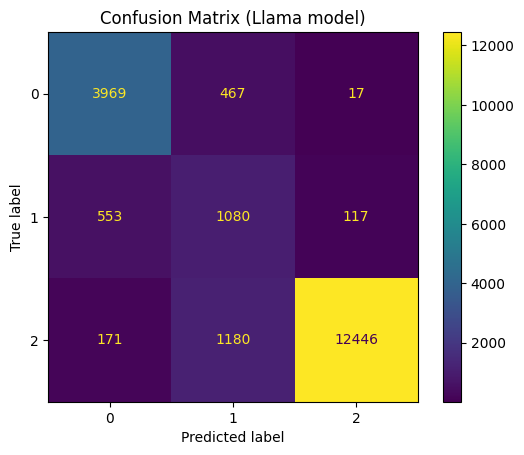

In [ ]:
# confusion matrix (incl. saving)
cm = confusion_matrix(y_true=y, y_pred=pred_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (Llama model)")
path = os.path.join(run_outdir, "confusion_matrix.png")
plt.savefig(path, bbox_inches='tight')
plt.show()

In [ ]:
# evaluate time
# print("Training time in seconds:", train_time_seconds)
# print("Training time per sample:", train_time_per_sample)
print("Prediction time in seconds:", pred_time_seconds)
print("Prediction time per sample:", pred_time_per_sample)

Prediction time in seconds: 3505.5894028779994
Prediction time per sample: 0.17527947014389997


In [ ]:
# saving results in team_comparison_results
results_comparison = {
    "n_samples": len(x),
    # "train_seconds": train_time_seconds,
    "pred_time_seconds": pred_time_seconds,
    "pred_time_per_sample": pred_time_per_sample,
    "metrics": metrics}

utils.save_results_csv(
    results=results_comparison,
    csv_path=os.path.join("outputs", "team_comparison_results.csv"),
    model_name=f"{model_name}_zeroshot",
    extra_info={"run_outdir": run_outdir})

Appended results to outputs/team_comparison_results.csv


In [ ]:
# saving all results in dictionary
results_all = results_comparison
results_all["train_time_seconds"] = None,
results_all["train_time_per_sample"] = None,
results_all["model"] = f"{model_name}_zeroshot",
results_all["instruction"] = instruction
path = os.path.join(run_outdir, "results_all.json")
with open(path, "w") as f:
    json.dump(results_all, f, indent=2)
